In [11]:
from scipy.io import loadmat
import cv2
from matplotlib import pyplot as plt
import os
import numpy as np

# Examine the dataset

In [2]:
data = loadmat("emotic/Annotations/annotations.mat")
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'test', 'train', 'val'])


In [3]:
train_data = data['train'][0]  # Access the array of structs
print(len(train_data))         # Number of annotated samples
print(train_data.dtype)        # See what fields each entry has

17077
[('filename', 'O'), ('folder', 'O'), ('image_size', 'O'), ('original_database', 'O'), ('person', 'O')]


In [4]:
sample = train_data[0]
print(sample['filename'][0])
print(sample['folder'][0])
print(sample['image_size'][0])
print(sample['original_database'][0])
print(sample['person'][0])

COCO_val2014_000000562243.jpg
mscoco/images
[(array([[640]], dtype=uint16), array([[640]], dtype=uint16))]
[(array(['mscoco'], dtype='<U6'), array([[(array([[562243]], dtype=int32), array([[448867]], dtype=int32))]],
       dtype=[('image_id', 'O'), ('annotations_id', 'O')]))                                                  ]
[(array([[ 86,  58, 564, 628]], dtype=uint16), array([[(array([[array(['Disconnection'], dtype='<U13'),
                 array(['Doubt/Confusion'], dtype='<U15')]], dtype=object),)]],
       dtype=[('categories', 'O')]), array([[(array([[5]], dtype=uint8), array([[3]], dtype=uint8), array([[9]], dtype=uint8))]],
       dtype=[('valence', 'O'), ('arousal', 'O'), ('dominance', 'O')]), array(['Male'], dtype='<U4'), array(['Adult'], dtype='<U5'))]


In [5]:
person_data = sample['person'][0][0]  # first person in that image
print(person_data.dtype)

[('body_bbox', 'O'), ('annotations_categories', 'O'), ('annotations_continuous', 'O'), ('gender', 'O'), ('age', 'O')]


In [6]:
print(person_data['body_bbox'][0][0])
print(person_data['annotations_categories'][0])
print(person_data['annotations_continuous'][0][0])
print(person_data['gender'][0][0])
print(person_data['age'][0][0])

86
[(array([[array(['Disconnection'], dtype='<U13'),
         array(['Doubt/Confusion'], dtype='<U15')]], dtype=object),)]
(array([[5]], dtype=uint8), array([[3]], dtype=uint8), array([[9]], dtype=uint8))
M
A


In [7]:
# Unzip the image file
# !unzip emodb_small.zip -d /content/emotic

# Load a single image and its cropped image

In [13]:
i = 49
while True:
  sample = train_data[i]
  folder = ''.join(sample['folder'][0])  # convert to string
  if folder == 'emodb_small/images':
    break
  i += 1

filename = ''.join(sample['filename'][0])

print("Index:", i)
print("Folder:", folder)
print("Filename:", filename)


person_data = sample['person'][0][0]

Index: 72
Folder: emodb_small/images
Filename: 78tk87458zwsmxaoi7.jpg


emotic\emodb_small/images\78tk87458zwsmxaoi7.jpg
image_path = 'emotic\\emodb_small/images\\78tk87458zwsmxaoi7.jpg'
Exists on disk: True
bbox: 122.0 1.0 374.0 222.0


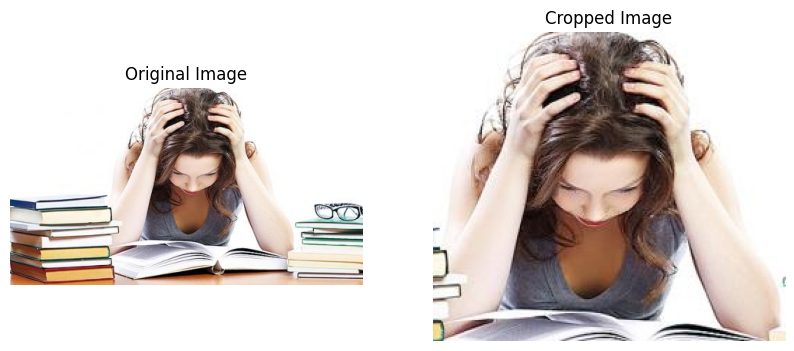

In [15]:
image_path = os.path.join("emotic", folder, filename)
print(image_path)
print("image_path =", repr(image_path))
print("Exists on disk:", os.path.exists(image_path))

img = cv2.imread(image_path)

# Convert BGR (OpenCV default) to RGB for display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Define person to look at
person_data = sample['person'][0][0]
x1, y1, x2, y2 = person_data['body_bbox'][0]
print("bbox:", x1, y1, x2, y2)

# === 2. Define a crop region ===
# You can replace these with actual bbox coords from EMOTIC, e.g. [x1, y1, x2, y2]
x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
cropped = img_rgb[y1:y2, x1:x2]

# === 3. Display original and cropped ===
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cropped)
plt.title("Cropped Image")
plt.axis('off')

plt.show()